# Part 0: Setup and Loading Data
From the NLTK library and between the two data choices, I picked Gutenberg - 'austen-emma.txt' or 'carroll-alice.txt'.

In [4]:
import nltk
from nltk.corpus import gutenberg

nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
book_id = 'austen-emma.txt'
raw_sentences = gutenberg.sents(book_id)

print(f'Number of sentences: {len(raw_sentences)}')
print(f'Example Sentence: {raw_sentences[0]}')

Number of sentences: 7752
Example Sentence: ['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']']


# Part A: Preprocessing and cleaning of text
We must handle lowercase letters, removing punctuation, and stopwords.
We won't use stemming to generate grammatically correct text.
We won't use lemmatization because it can destroy tense and nuances in its outputs.

Total Tokens (After cleaning): 73149
Vocabulary Size (Unique words): 6948 



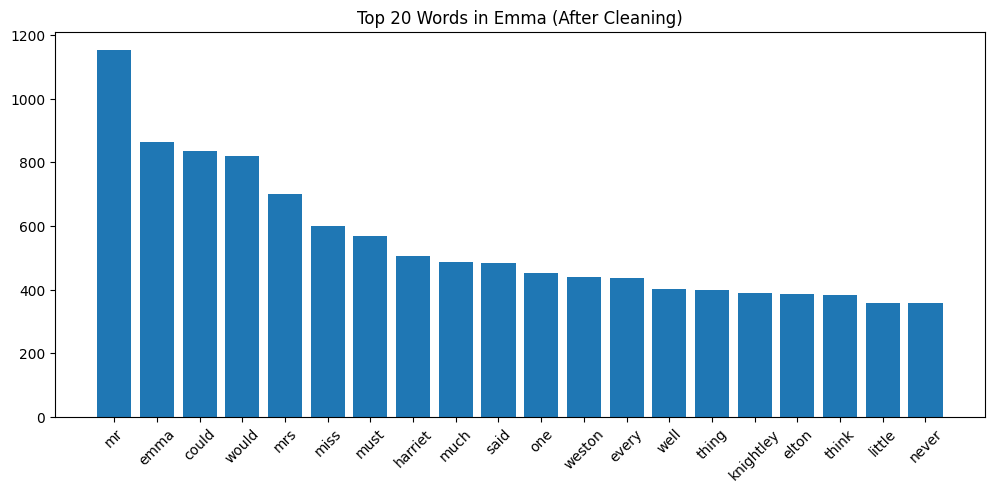

In [15]:
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from collections import Counter

def clean_text(sentences):
  stop_words = set(stopwords.words('english'))
  cleaned = []

  for sentence in sentences:
    new_sent = []
    for word in sentence:
      w = word.lower()
      if w.isalpha() and w not in stop_words:
        new_sent.append(w)

    if len(new_sent) > 0:
      cleaned.append(new_sent)

  return cleaned

clean_corpus = clean_text(raw_sentences)
flat_words = [word for sent in clean_corpus for word in sent]

print(f"Total Tokens (After cleaning): {len(flat_words)}")
print(f"Vocabulary Size (Unique words): {len(set(flat_words))} \n")

counts = Counter(flat_words)
top_20 = counts.most_common(20)
words, freqs = zip(*top_20)

plt.figure(figsize=(12, 5))
plt.bar(words, freqs)
plt.title("Top 20 Words in Emma (After Cleaning)")
plt.xticks(rotation=45)
plt.show()

## A3. Reflection (short)
### In 5-8 sentences, explain how your preprocessing choices could affect downstream tasks (vectorization, language modeling, and embeddings).

#### Answer: My preprocessing choices such as lowercase and removing of puntuation made the vocabulary size smaller while getting rid of noise allowing for Word2Vec model to pick up semantic relations rather tan different  formatting. I chose not to use stemming or lemmatization tp ensure that "run" and "running" remain separate tokens. This decision was important for our N-Gram language model. If we had stemmed the text, the generator would have outputted non-words like "happili" instead of "happily," ruining the readability of the generated sentences. The trade-off with that is that my vocabulary remains larger, which splits the probability mass in the N-Gram model and potentially increases perplexity since the model cannot share statistics between "walk" and "walking." Lastly, removing stopwords improves the quality of the word embeddings by ensuring the context windows in Word2Vec are filled with meaningful content words rather than noise like "the" or "and.

# Part B: N-gram Model
We will use **Bigram Model** that essentially predicts word based on 1 previous word.

In [21]:
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from sklearn.model_selection import train_test_split

# Train Test Split
train_sents, test_sents = train_test_split(clean_corpus, test_size=0.2, random_state=42)

print(f'Training Sentences: {len(train_sents)}')
print(f'Testing Sentences: {len(test_sents)} \n')

Training Sentences: 6138
Testing Sentences: 1535 



### Train BIGRAM MODEL and calculate MLE = Maximum Likelihood Estimation
##### - MLE simply counts how often "Emma" is followed by "Woodhouse" vs "said"

In [23]:
n = 2 # BIGRAM
train_data, padded_sents = padded_everygram_pipeline(n, train_sents)

model = MLE(n)
model.fit(train_data, padded_sents)

print(f"\nModel Training Finished :) \n")
print(f"Vocabulary Size: {len(model.vocab)}")



Model Training Finished :) 

Vocabulary Size: 6339


### B3: PERPLEXITY EVALUATION
#### - We calculate perplexity on the TEST set then flatten test data for evaluation.
#### - The lower perplexity is better. It measures how "surprised" the model is by new text.

In [24]:
test_data, _ = padded_everygram_pipeline(n, test_sents)
test_ngrams = [ngram for sent in test_data for ngram in sent]

perplexity = model.perplexity(test_ngrams)
print(f"Model Perplexity on Test Set: {perplexity:.2f}")

Model Perplexity on Test Set: inf


#### Demo Example: Generate Text
##### Generate random text and clean up the output to look like a sentence

In [25]:
for i in range(3):
    generated = model.generate(10, random_seed=i)
    output = ' '.join([w for w in generated if w not in ['<s>', '</s>']])
    print(f"Sentence {i+1}: {output}")

Sentence 1: sorry opportunity married immediately followed plain dealing always mercy
Sentence 2: sure said emma humour mrs weston account
Sentence 3: weston wants smiling prosing undistinguishing unfastidious apt incline


# Part C: Word to Embedding
### Turning word into vectors so we can do relative math to them. Example King - Man = Women. For this we use Gensim Word2Vec that we learned during the lab.

### C1: TRAIN WORD2VEC
#### - vector_size=100: Dimensions of the vector
#### - window=5: Context window size
#### - min_count=2: Ignore rare words

In [27]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 32.5 MB/s eta 0:00:00


In [30]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=clean_corpus, vector_size=100, window=5, min_count=2, workers=4)

print("Word2Vec Model Training Done")
print(f"Vocabulary Size: {len(w2v_model.wv)}")

Word2Vec Model Training Done
Vocabulary Size: 4212


### C3: SIMILARITY QUERIES
#### Picking 5 frequent words from our corpus such as 'emma', 'friend', 'home', 'good', 'marriage'.

In [31]:
target_words = ['emma', 'friend', 'home', 'good', 'marriage']

print(f"\n--- TOP 10 SIMILAR WORDS ---")
for word in target_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"Word: '{word}' -> {similar}")
    else:
        print(f"Word '{word}' not in vocabulary.")



--- TOP 10 SIMILAR WORDS ---
Word: 'emma' -> [('might', 0.9998436570167542), ('little', 0.9998257160186768), ('time', 0.9998241662979126), ('even', 0.9998201727867126), ('still', 0.9998118281364441)]
Word: 'friend' -> [('harriet', 0.9998383522033691), ('found', 0.9998059272766113), ('little', 0.9998013377189636), ('first', 0.9997982978820801), ('think', 0.9997962117195129)]
Word: 'home' -> [('hartfield', 0.9998262524604797), ('might', 0.9998215436935425), ('two', 0.9998205900192261), ('first', 0.9998183846473694), ('highbury', 0.9998154640197754)]
Word: 'good' -> [('harriet', 0.999845564365387), ('much', 0.9998244047164917), ('might', 0.9998237490653992), ('must', 0.9998216032981873), ('though', 0.9998213052749634)]
Word: 'marriage' -> [('might', 0.9995285868644714), ('even', 0.999512255191803), ('right', 0.999505341053009), ('feelings', 0.999504566192627), ('without', 0.9994977712631226)]


### C4: ANALOGIES
#### - Format: positive=[A, B], negative=[C]  means  A + B - C
#### - Corpus specific analogy: emma - woman + man = ?
#### - Example: father - man + woman = mother


In [32]:
try:
    analogy = w2v_model.wv.most_similar(positive=['woman', 'father'], negative=['man'], topn=1)
    print(f"father - man + woman = {analogy[0][0]}")
except KeyError as e:
    print(f"Analogy failed (word missing): {e}")

try:
    analogy = w2v_model.wv.most_similar(positive=['man', 'emma'], negative=['woman'], topn=1)
    print(f"emma - woman + man = {analogy[0][0]}")
except KeyError:
    pass

father - man + woman = came
emma - woman + man = lady
